In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os, re
import cv2
import glob
import pathlib
import time
import datetime
from IPython import display
from PIL import Image

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 1. Augmentation 적용

## (1) 데이터 불러오기

In [2]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


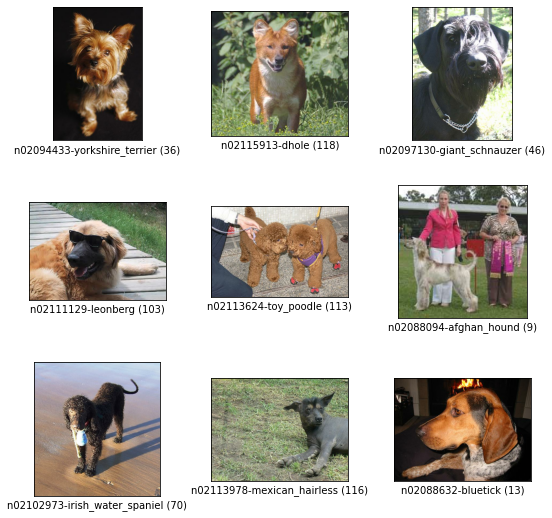

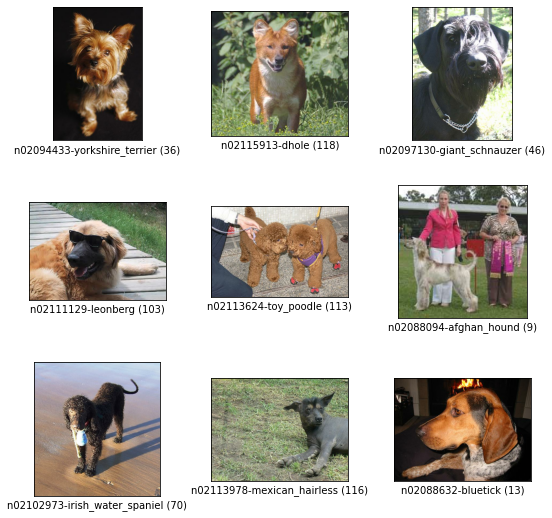

In [3]:
tfds.show_examples(ds_train, ds_info)

## (2) Augmentation 적용하기
텐서플로우 Random Augmentation API 사용하기

### 1) 데이터 전처리

In [4]:
def normalize_and_resize_img(image, label):
    # Normalizes images: 'uint8' -> 'float32'
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [5]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [6]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2       # 입력 데이터를 처리할 때 두 개의 병렬 스레드를 사용하여 처리
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,               # augment 함수 적용 (테스트 데이터셋에는 적용하지 않아야 함)
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)       # shuffle 함수 적용 (테스트 데이터셋에는 적용하지 않아야 함)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 2) Random Augmentation 직접 구현하기

In [7]:
def augment2(image, label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

## (3) 모델 만들기

비교 실험을 위해 ResNet-50 모델 두 개 만들기

In [9]:
num_classes = ds_info.features["label"].num_classes

resnet50_a = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

94781440/94765736 [==============================] - 0s 0us/step


In [11]:
aug_resnet50_a = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [13]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], as_supervised=True,
                                         shuffle_files=True, with_info=True)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## (4) 모델 훈련하기

In [14]:
EPOCH = 20

### 1) No Augmentation

In [15]:
resnet50_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                 loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_resnet50_no_aug = resnet50_a.fit(
    ds_train_no_aug,   # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 204s 208ms/step - loss: 2.2025 - accuracy: 0.4498 - val_loss: 3.4840 - val_accuracy: 0.1841
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 0.7440 - accuracy: 0.7948 - val_loss: 1.0805 - val_accuracy: 0.6806
Epoch 3/20
750/750 [==============================] - 156s 207ms/step - loss: 0.2762 - accuracy: 0.9408 - val_loss: 0.9824 - val_accuracy: 0.7095
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0838 - accuracy: 0.9905 - val_loss: 0.9066 - val_accuracy: 0.7378
Epoch 5/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0310 - accuracy: 0.9982 - val_loss: 0.9183 - val_accuracy: 0.7366
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0174 - accuracy: 0.9997 - val_loss: 0.9206 - val_accuracy: 0.7434
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0130 - accuracy: 0.9998 - val_loss: 0.9336 -

### 2) With Augmenation

In [16]:
aug_resnet50_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                     loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_resnet50_aug = aug_resnet50_a.fit(
    ds_train_aug,   # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 163s 209ms/step - loss: 2.2680 - accuracy: 0.4293 - val_loss: 2.7912 - val_accuracy: 0.2849
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 0.9422 - accuracy: 0.7327 - val_loss: 1.2882 - val_accuracy: 0.6307
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 0.5088 - accuracy: 0.8594 - val_loss: 1.0670 - val_accuracy: 0.6966
Epoch 4/20
750/750 [==============================] - 156s 207ms/step - loss: 0.2668 - accuracy: 0.9344 - val_loss: 1.0445 - val_accuracy: 0.6995
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 0.1561 - accuracy: 0.9685 - val_loss: 1.1799 - val_accuracy: 0.6670
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0931 - accuracy: 0.9835 - val_loss: 0.9565 - val_accuracy: 0.7386
Epoch 7/20
750/750 [==============================] - 156s 207ms/step - loss: 0.0574 - accuracy: 0.9927 - val_loss: 0.9414 -

## (5) 훈련 과정 시각화하기

### 1) 훈련 과정 시각화

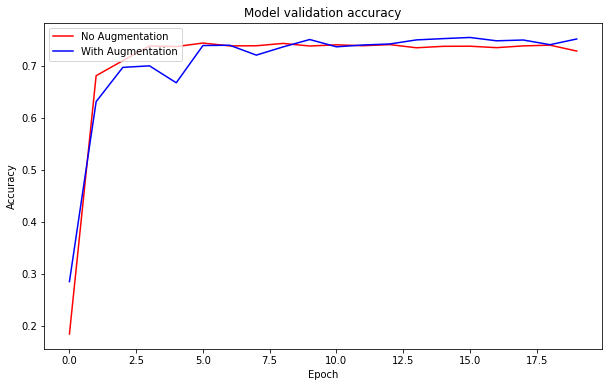

In [18]:
plt.figure(figsize = (10, 6))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

### 2) 훈련 과정 확대 시각화

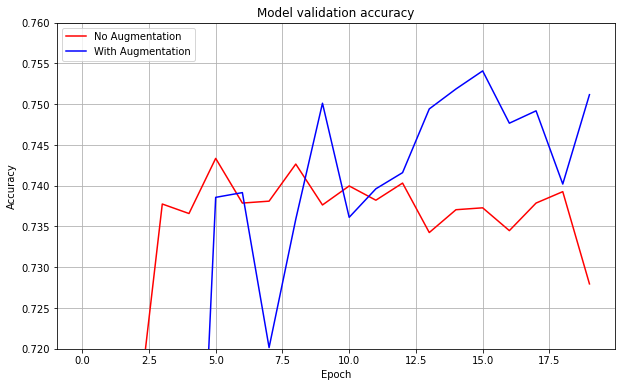

In [20]:
plt.figure(figsize = (10, 6))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

## (6) 심화 기법 (1) Cutmix Augmentation

### 1) 이미지 섞기

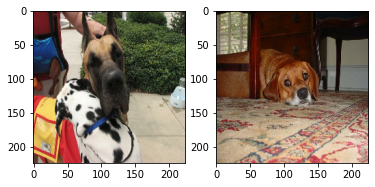

In [22]:
# 데이터셋에서 이미지 2개를 가져옴
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [24]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(86, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(112, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


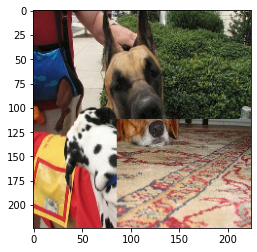

In [26]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :]              # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]        # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]  # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 2) 라벨 섞기

In [28]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3080357 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [30]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## (7) 심화 기법 (2) Mixup Augmentation

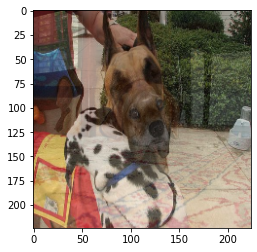

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.34158325
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.65841675
 0.         0.         0.    

In [32]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image = (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [34]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 2. Project_CutMix_vs_Mixup

CutMix 또는 Mixup 비교실험 하기

## (1) Augmentation을 적용한 데이터셋 만들기

### 1) 데이터 불러오기

In [35]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], as_supervised=True, shuffle_files=True, with_info=True)

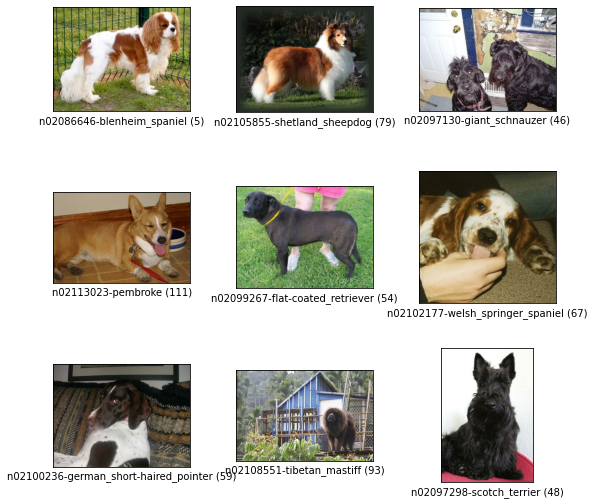

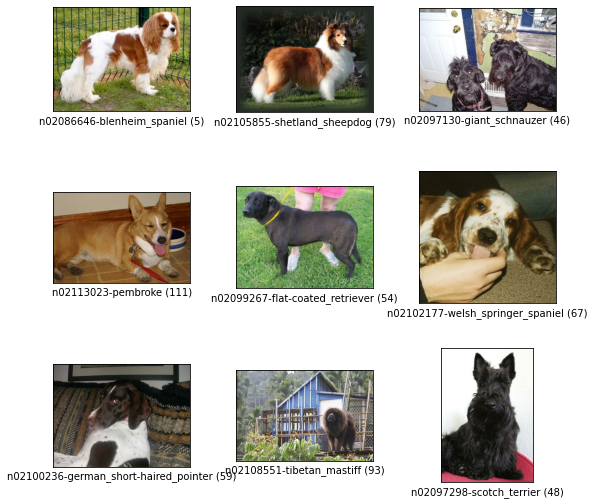

In [36]:
tfds.show_examples(ds_train, ds_info)

In [37]:
num_classes = ds_info.features["label"].num_classes

### 2) Cutmix Augmentation

#### - (1) 이미지 섞기

In [38]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max


# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

#### - (2) 라벨 섞기

In [39]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = 224
    image_size_y = 224
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label


def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 3) Mixup Augmentation

In [40]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 4) 데이터 전처리

In [41]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=True):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
        )
    
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )     
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [42]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## (2) 모델 만들기

비교 실험을 위해 ResNet-50 모델 네 개 만들기

In [43]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [44]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [45]:
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [46]:
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

## (3) 모델 훈련하기

위에서 만든 CutMix나 Mixup을 사용하기 위해서는 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해야 한다. cutmix(), mixup()을 구현하면서 label의 mix 때문에 더 이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문이다.

In [47]:
EPOCH = 20

### 1) No Augmentation

In [48]:
resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                 loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,   # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 165s 210ms/step - loss: 3.6942 - accuracy: 0.2444 - val_loss: 3.5891 - val_accuracy: 0.1818
Epoch 2/20
750/750 [==============================] - 171s 228ms/step - loss: 2.8460 - accuracy: 0.4889 - val_loss: 1.4604 - val_accuracy: 0.5934
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 2.5515 - accuracy: 0.5907 - val_loss: 1.3990 - val_accuracy: 0.6217
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 2.3683 - accuracy: 0.6586 - val_loss: 1.3688 - val_accuracy: 0.6234
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 2.2195 - accuracy: 0.7198 - val_loss: 1.3754 - val_accuracy: 0.6255
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 2.1311 - accuracy: 0.7502 - val_loss: 1.1826 - val_accuracy: 0.6807
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 2.0595 - accuracy: 0.7769 - val_loss: 1.1988 -

### 2) With Augmentation

In [49]:
aug_resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                     loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,      # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 167s 211ms/step - loss: 3.7852 - accuracy: 0.2310 - val_loss: 4.0133 - val_accuracy: 0.1090
Epoch 2/20
750/750 [==============================] - 157s 209ms/step - loss: 2.9488 - accuracy: 0.4468 - val_loss: 1.5276 - val_accuracy: 0.5778
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 2.6787 - accuracy: 0.5407 - val_loss: 1.6013 - val_accuracy: 0.5571
Epoch 4/20
750/750 [==============================] - 171s 229ms/step - loss: 2.5179 - accuracy: 0.6029 - val_loss: 1.3288 - val_accuracy: 0.6295
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 2.3972 - accuracy: 0.6406 - val_loss: 1.2135 - val_accuracy: 0.6579
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 2.3022 - accuracy: 0.6835 - val_loss: 1.3886 - val_accuracy: 0.6228
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 2.2215 - accuracy: 0.7113 - val_loss: 1.2430 -

### 3) With Augmentation + CutMix 적용

In [50]:
cutmix_aug_resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                 loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50_cutmix_aug = cutmix_aug_resnet50.fit(
    ds_train_cutmix_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 168s 211ms/step - loss: 3.8995 - accuracy: 0.1948 - val_loss: 3.0647 - val_accuracy: 0.2622
Epoch 2/20
750/750 [==============================] - 157s 209ms/step - loss: 3.0537 - accuracy: 0.3998 - val_loss: 1.5483 - val_accuracy: 0.5628
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 2.7686 - accuracy: 0.4863 - val_loss: 1.2785 - val_accuracy: 0.6407
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 2.5827 - accuracy: 0.5452 - val_loss: 1.4371 - val_accuracy: 0.6024
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 2.4543 - accuracy: 0.5807 - val_loss: 1.2839 - val_accuracy: 0.6470
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 2.3328 - accuracy: 0.6177 - val_loss: 1.3066 - val_accuracy: 0.6438
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 2.2566 - accuracy: 0.6430 - val_loss: 1.2737 -

### 4) With Augmentation + Mixup 적용

In [51]:
mixup_aug_resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                 loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50_mixup_aug = mixup_aug_resnet50.fit(
    ds_train_mixup_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 167s 211ms/step - loss: 3.7756 - accuracy: 0.2227 - val_loss: 3.8748 - val_accuracy: 0.1334
Epoch 2/20
750/750 [==============================] - 157s 210ms/step - loss: 2.9405 - accuracy: 0.4440 - val_loss: 1.5434 - val_accuracy: 0.5712
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 2.6577 - accuracy: 0.5546 - val_loss: 1.4576 - val_accuracy: 0.5951
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 2.5101 - accuracy: 0.6053 - val_loss: 1.3202 - val_accuracy: 0.6339
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 2.4017 - accuracy: 0.6503 - val_loss: 1.3041 - val_accuracy: 0.6336
Epoch 6/20
750/750 [==============================] - 157s 210ms/step - loss: 2.2841 - accuracy: 0.6888 - val_loss: 1.4741 - val_accuracy: 0.6049
Epoch 7/20
750/750 [==============================] - 157s 210ms/step - loss: 2.2439 - accuracy: 0.7058 - val_loss: 1.2376 -

## (4) 훈련 과정 시각화하기

### 1) 훈련 과정 시각화

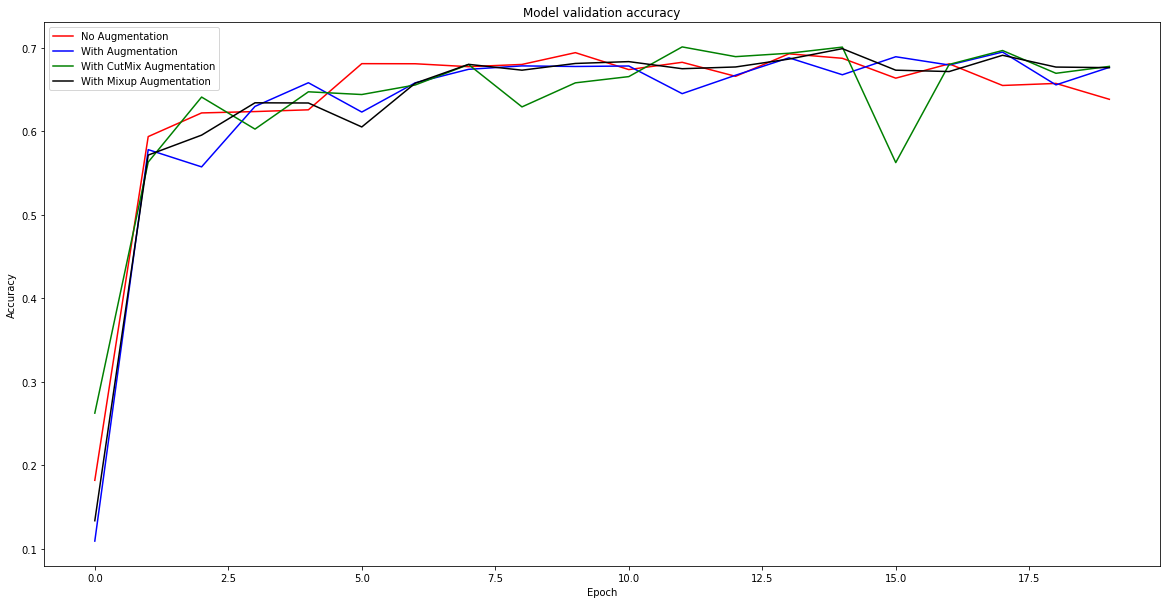

In [52]:
plt.figure(figsize = (20, 10))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix Augmentation', 'With Mixup Augmentation'], loc='upper left')
plt.show()

### 2) 훈련 과정 확대 시각화

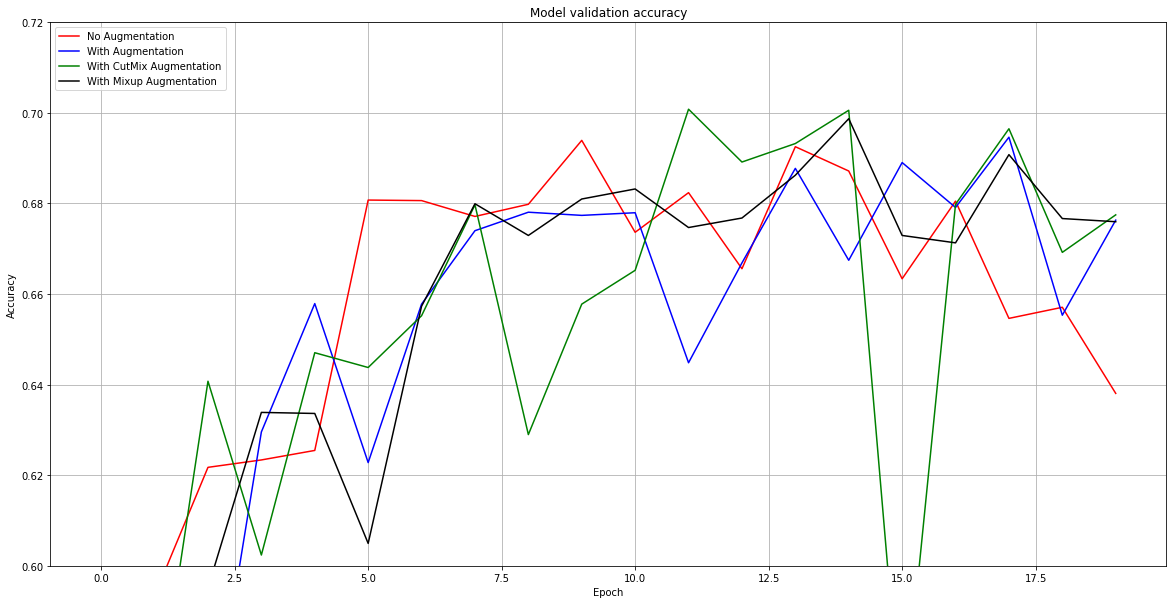

In [53]:
plt.figure(figsize = (20, 10))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix Augmentation', 'With Mixup Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.72)
plt.show()

# 3. Conclusion

### <Augmentation에 의한 모델 간 성능 비교>

____________________________________________________________________________________________________________________

### 1. [No Augmentation]

Augmentation을 적용하지 않은 경우, 모델이 학습하는 데이터의 다양성이 부족하게 되어, 모델이 일반화하는 데 어려움이 생길 수 있다. 따라서, epoch가 증가함에 따라 모델의 정확도가 감소할 수 있다.

- 성능: 이미지 데이터가 부족한 경우 과적합 문제가 발생할 가능성이 높아지며, 모델의 일반화 성능이 떨어질 수 있다.

- 장점: 데이터 증강 기술을 적용하지 않아도 모델의 학습 및 추론이 빠르고 간단해진다.

____________________________________________________________________________________________________________________

### 2. [With Augmentation]

Augmentation을 적용한 경우, 모델이 학습하는 데이터의 다양성이 증가하여, 모델이 일반화하는 데 더욱 유리해진다. 이러한 경우, epoch가 증가함에 따라 모델의 Accuracy가 일정한 값에 수렴하게 된다.

- 성능: 이미지 데이터 증강 기술을 적용하면 데이터의 다양성과 양을 증가시키므로 모델의 일반화 성능이 향상될 수 있다.

- 장점: 데이터의 다양성을 증가시켜 모델의 성능을 높일 수 있다.
____________________________________________________________________________________________________________________

### 3. [With Augmentation + Cutmix 적용]

Cutmix는 이미지를 잘라서 다른 이미지와 섞는 기법이다. Cutmix를 적용한 경우, 이미지에 대한 정보가 더욱 세밀하게 학습되기 때문에 모델의 Accuracy가 증가할 수 있다. 그러나, Cutmix는 이미지를 섞는 과정에서 정보의 일부가 유실될 수 있기 때문에, epoch가 증가함에 따라 모델의 Accuracy가 등락할 수 있다.

- 성능: CutMix를 사용하면 모델의 성능이 향상될 수 있다. 일부 데이터셋에서는 기존의 augmentation 기법보다 더 좋은 성능을 보이기도 한다.

- 장단점: CutMix를 적용하면 모델의 성능이 향상될 수 있지만, 이미지 내의 중요한 정보가 사라지는 문제가 발생할 수 있다.
____________________________________________________________________________________________________________________

### 4. [With Augmentation + Mixup 적용]

Mixup은 이미지를 섞는 기법으로, 두 이미지를 섞어 하나의 새로운 이미지를 생성한다. Mixup를 적용한 경우, 이미지에 대한 정보의 유실이 없기 때문에, epoch가 증가함에 따라 모델의 Accuracy가 안정적으로 상승할 수 있다.

- 성능: Mixup을 사용하면 모델의 성능이 향상될 수 있다. 일부 데이터셋에서는 기존의 augmentation 기법보다 더 좋은 성능을 보이기도 한다.

- 장단점: Mixup을 적용하면 모델의 성능이 향상될 수 있지만, 이미지 내의 중요한 정보가 사라지는 문제가 발생할 수 있다. 또한, Mixup은 픽셀 값이 선형적으로 섞이기 때문에 이미지 내의 각 요소들이 서로 다른 가중치를 가지는 것과 같은 형태의 데이터에는 적용하기 어려울 수 있다. 이러한 경우에는 CutMix나 다른 증강 기법을 적용하는 것이 더 적절할 수 있다.
____________________________________________________________________________________________________________________

Epoch의 수가 10이상인 경우에는 일반화 능력의 향상으로 인해 No Augmentation을 제외한 모든 기술의 Accuracy가 0.68 정도에 수렴해가므로 3가지 중 어떤 것을 사용해도 무방해보인다. 그러나 이미지에 대한 정보의 유실이 없는 With Augmentation + Mixup의 방법을 사용하면 epoch가 증가함에 따라 모델의 Accuracy가 안정적으로 상승하므로, 위의 실험을 통해 분석된 Image Augmentation을 위한 최적의 방법은 Augmentation + Mixup을 사용한 경우라고 할 수 있다.

# 4. References

[1] https://lms.aiffel.io/course/405/node/465

[2] https://www.google.com/